# Meeting 17.04.2025
Visualization of the error of a subset of interesting prompts

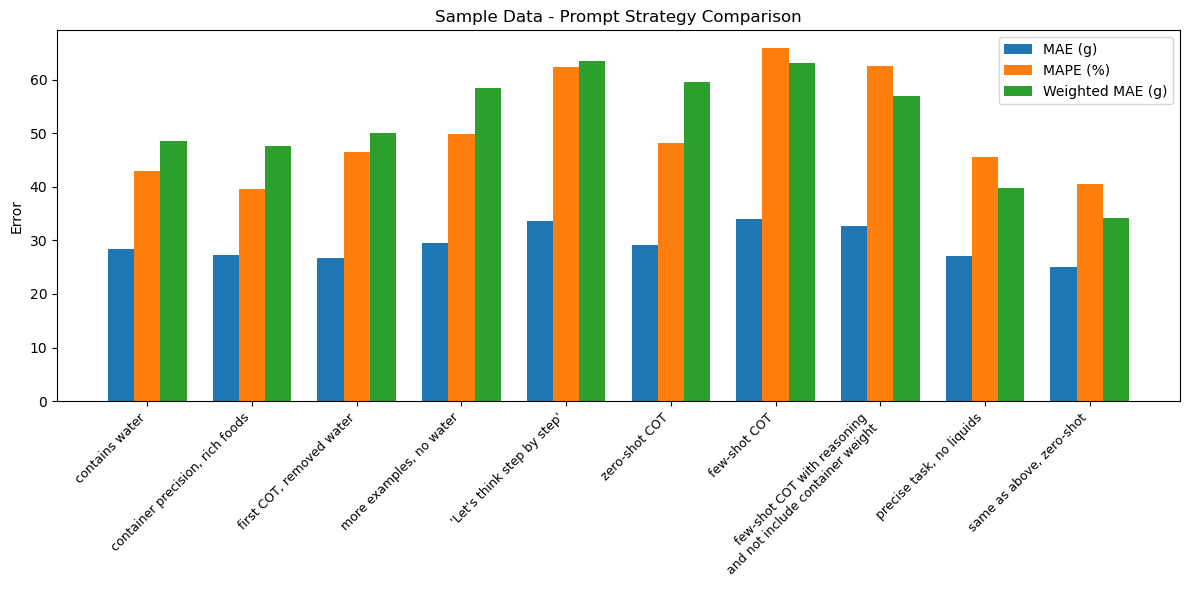

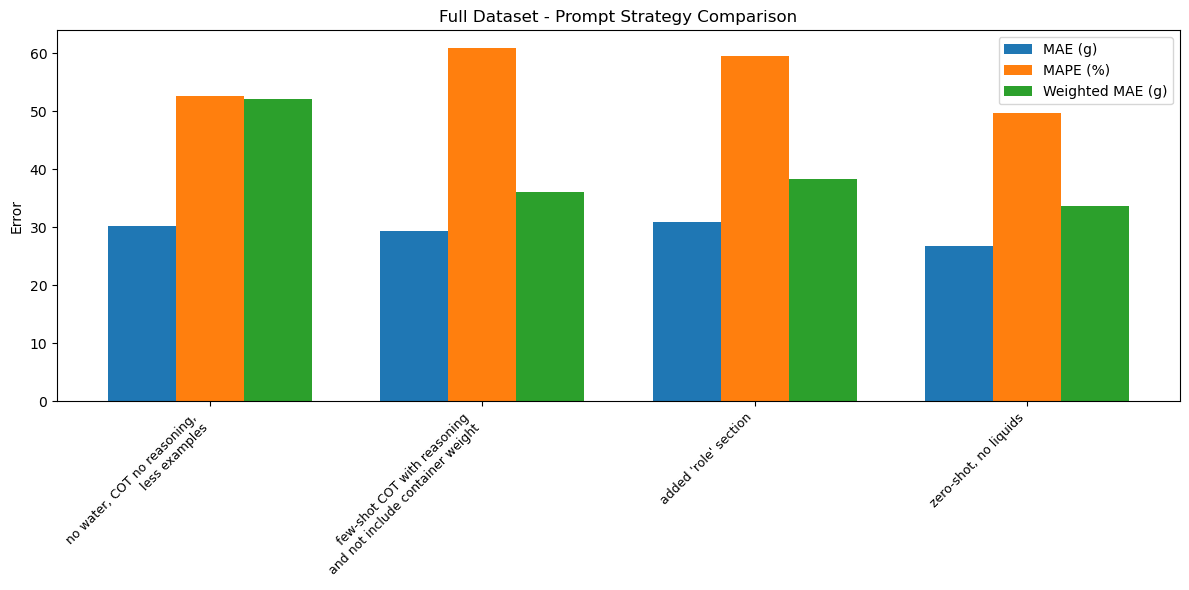

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrames from the provided data

data = [
    ("../data/result/result_7aa63dcf-66f6-4758-b280-5680318bfc29.json", 28.34, 42.87, 48.53, "sample", "contains water"),
    ("../data/result/result_bf71e825-bbae-4e17-a0f4-6d96783d6708.json", 27.18, 39.51, 47.64, "sample", "container precision, rich foods"),
    ("../data/result/result_52a9cff1-1b49-43b9-aa8a-baf2e1016fc9.json", 26.62, 46.56, 50.04, "sample", "first COT, removed water"),
    ("../data/result/result_a97df4c7-2866-4a9f-b673-45bc2488da6e.json", 29.46, 49.76, 58.42, "sample", "more examples, no water"),
    ("../data/result/result_cc37a6b3-b8f6-4e62-b208-e65539a8f94e.json", 33.60, 62.42, 63.42, "sample", "'Let's think step by step'"),
    ("../data/result/result_d27c6de6-cb64-4f00-9ecd-b3cfaf25deee.json", 30.16, 52.60, 52.09, "full", "no water, COT no reasoning,\n less examples"),
    ("../data/result/result_bc3b5069-6b39-4789-984e-fcbffa97a2ae.json", 29.16, 48.22, 59.60, "sample", "zero-shot COT"),
    ("../data/result/result_3282d95c-8a1b-44f5-ad39-7057019c2264.json", 33.97, 65.88, 63.12, "sample", "few-shot COT"),
    ("../data/result/result_17ab87b1-5fab-438e-8325-712a0adf425a.json", 32.59, 62.47, 57.01, "sample", "few-shot COT with reasoning\n and not include container weight"),
    ("../data/result/result_d392ac97-00d5-4499-9420-f57494015c25.json", 29.27, 60.89, 36.10, "full", "few-shot COT with reasoning\n and not include container weight"),
    ("../data/result/result_1ab7b2ad-b2a6-4608-81d6-cebcca796fc2.json", 30.95, 59.58, 38.28, "full", "added 'role' section"),
    ("../data/result/result_28454b6a-2c2b-4183-ba36-a815d4a9e888.json", 27.10, 45.57, 39.71, "sample", "precise task, no liquids"),
    ("../data/result/result_b28d51e3-4961-4555-a305-4ee7ba35f137.json", 24.97, 40.56, 34.10, "sample", "same as above, zero-shot"),
    ("../data/result/result_a5d2269f-440b-4759-9bcf-3dba93d9c9e2.json", 26.82, 49.69, 33.71, "full", "zero-shot, no liquids")
]

# Combine and prepare data
columns = ["file", "MAE", "MAPE", "Weighted_MAE", "type", "description"]
df = pd.DataFrame(data, columns=columns)
# Split data
df_sample = df[df["type"] == "sample"]
df_full = df[df["type"] == "full"]

# Function to plot one group
def plot_metrics(df_subset, title, color="black"):
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    x = range(len(df_subset))
    
    ax.bar([i - bar_width for i in x], df_subset["MAE"], width=bar_width, label="MAE (g)")
    ax.bar(x, df_subset["MAPE"], width=bar_width, label="MAPE (%)")
    ax.bar([i + bar_width for i in x], df_subset["Weighted_MAE"], width=bar_width, label="Weighted MAE (g)")

    ax.set_xticks(x)
    ax.set_xticklabels(df_subset["description"], rotation=45, ha="right", fontsize=9, color=color)
    ax.set_ylabel("Error")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot sample data
plot_metrics(df_sample, "Sample Data - Prompt Strategy Comparison")

# Plot full data with colored description labels
plot_metrics(df_full, "Full Dataset - Prompt Strategy Comparison")


# Meeting 01.05.2025
Visualization of the error of a subset of interesting prompts


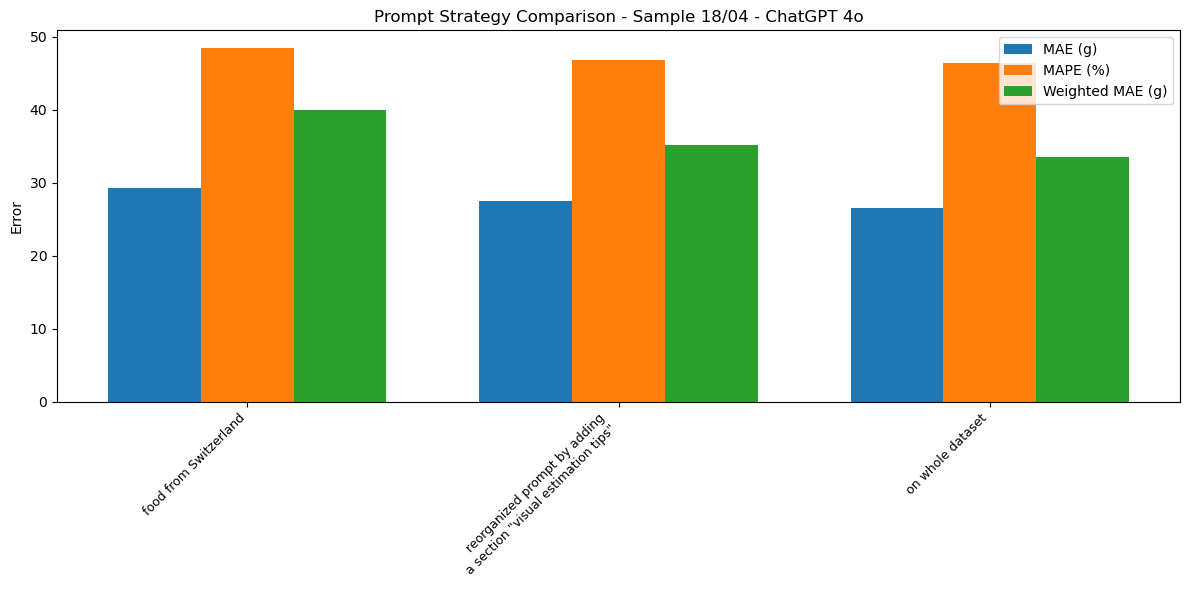

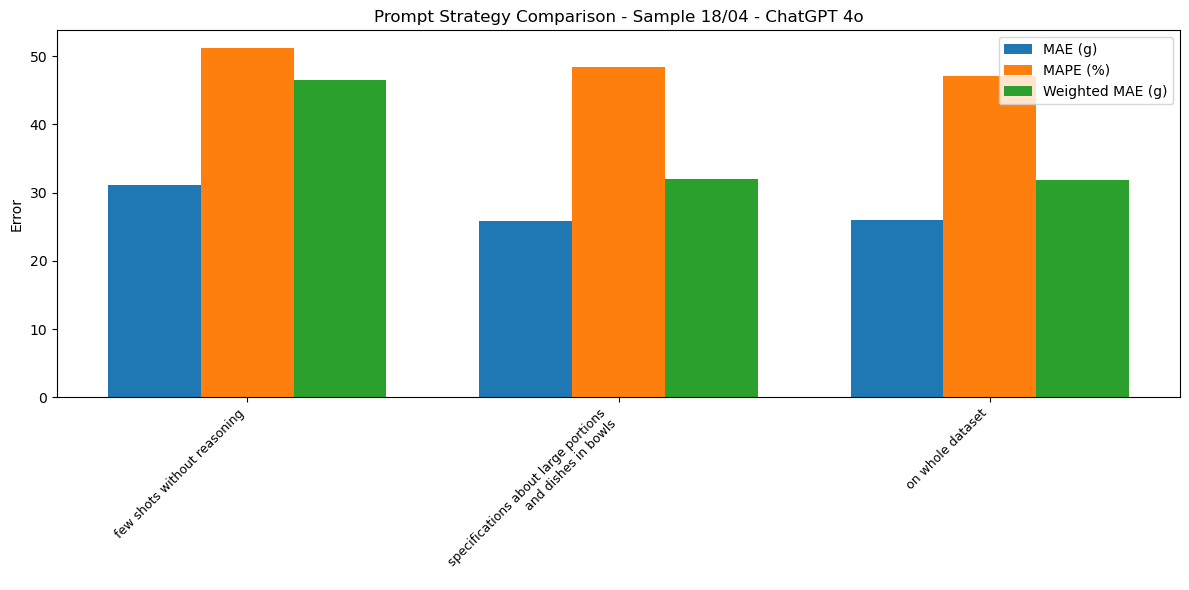

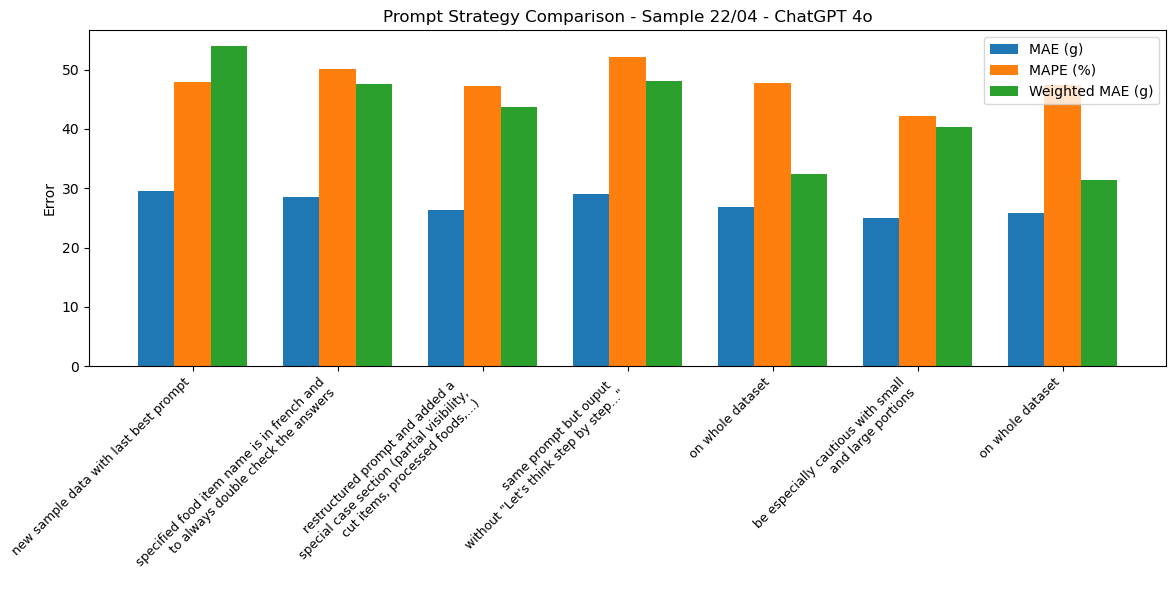

In [28]:
# Function to plot one group
def plot_metrics(df_subset, title, color="black", label="plot_desc"):
    df_subset.dropna(subset=[label], inplace=True)

    # Replace all literal "\n" with real line breaks in the 'plot_desc' column
    df_subset[label] = df_subset[label].str.replace(r"\\n", "\n", regex=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.25
    x = range(len(df_subset))
    
    ax.bar([i - bar_width for i in x], df_subset["MAE"], width=bar_width, label="MAE (g)")
    ax.bar(x, df_subset["MAPE"], width=bar_width, label="MAPE (%)")
    ax.bar([i + bar_width for i in x], df_subset["Weighted_MAE"], width=bar_width, label="Weighted MAE (g)")

    ax.set_xticks(x)
    ax.set_xticklabels(df_subset[label], rotation=45, ha="right", fontsize=9, color=color)
    ax.set_ylabel("Error")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot sample data
df = pd.read_csv("./metrics_results.csv")

df1 = df.iloc[26:31].copy()
plot_metrics(df1, "Prompt Strategy Comparison - Sample 18/04 - ChatGPT 4o")

df2 = df.iloc[31:39].copy()
plot_metrics(df2, "Prompt Strategy Comparison - Sample 18/04 - ChatGPT 4o")

df3 = df.iloc[39:54].copy()
plot_metrics(df3, "Prompt Strategy Comparison - Sample 22/04 - ChatGPT 4o")


# Meeting 15.05.2025
Computation of the distribution of the error  
Comparison of different models with the same prompt

45.41% of dishes account for 80% of the total Weighted MAE.
Top errors saved to ./top_80_percent_error.csv.

22.63% of food items account for 80% of the total Weighted MAE.
Top errors saved to ./top_80_percent_items_error.csv.


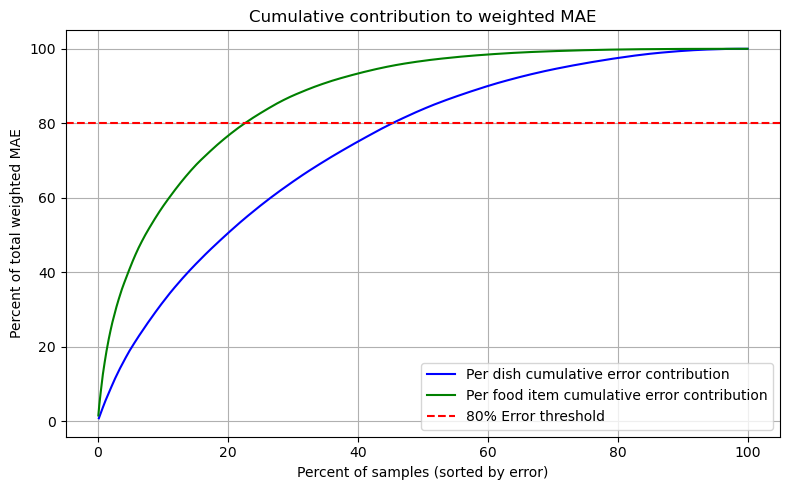

In [29]:
import numpy as np

error_file = "sorted_result_d19c3270-5f4c-4cfb-9e21-8d7e14ece178.csv"
df_error = pd.read_csv(f"../data/comparison/{error_file}")

# Replace empty strings with NaN and drop incomplete rows
df_error.replace("", np.nan, inplace=True)
df_error.dropna(subset=["absolute_error", "weight", "weighed_absolute_error"], inplace=True)

# Ensure correct types
df_error["absolute_error"] = df_error["absolute_error"].astype(float)
df_error["weight"] = df_error["weight"].astype(float)
df_error["weighed_absolute_error"] = df_error["weighed_absolute_error"].astype(float)

# ------------------------
# Per-dish analysis
# ------------------------
# Keep only one row per image_id (since total_dish_wmae is already summed per dish)
df_unique = df_error.drop_duplicates(subset=["url"])
# Sort by error
df_sorted = df_unique.sort_values("total_dish_wmae", ascending=False) # Already sorted but keep this for safety

# Total weighted error
mae = df_sorted["total_dish_wmae"].mean()
total_error = df_sorted["total_dish_wmae"].sum()

# Compute cumulative contribution
df_sorted["cumulative_error"] = df_sorted["total_dish_wmae"].cumsum()
df_sorted["fraction_of_total_error"] = 100 * df_sorted["cumulative_error"] / total_error
df_sorted["fraction_of_dishes"] = 100 * (np.arange(len(df_sorted)) + 1) / len(df_sorted)

# Find the point where 80% of the error is reached
threshold_row = df_sorted[df_sorted["fraction_of_total_error"] >= 80].iloc[0]
fraction_of_dishes_for_80 = threshold_row["fraction_of_dishes"] 
print(f"{fraction_of_dishes_for_80:.2f}% of dishes account for 80% of the total Weighted MAE.")

# Export those top samples to a CSV
threshold_index = df_sorted[df_sorted["fraction_of_total_error"] <= 80].shape[0]
top_80 = df_sorted.iloc[:threshold_index]
top_80_file = "./top_80_percent_error.csv"
top_80.to_csv(top_80_file, index=False)
print(f"Top errors saved to {top_80_file}.\n")

# ------------------------
# Per-food-item analysis
# ------------------------
# Sort by weighed_absolute_error (which in this context acts as item-wise weighted error)
df_items_sorted = df_error.sort_values("weighed_absolute_error", ascending=False).copy()  # Already sorted but keep this for safety
df_items_sorted = df_error.sort_values("weighed_absolute_error", ascending=False).reset_index(drop=True)

# Compute cumulative contribution of food items
total_error_items = df_items_sorted["weighed_absolute_error"].sum()
df_items_sorted["cumulative_error"] = df_items_sorted["weighed_absolute_error"].cumsum()
df_items_sorted["fraction_of_total_error"] = 100 * df_items_sorted["cumulative_error"] / total_error_items
df_items_sorted["fraction_of_items"] = 100 * (df_items_sorted.index + 1) / len(df_items_sorted)

# Find how many food items account for 80% of total error
threshold_row_item = df_items_sorted[df_items_sorted["fraction_of_total_error"] >= 80].iloc[0]
fraction_items_80 = threshold_row_item["fraction_of_items"]

# Output result
print(f"{fraction_items_80:.2f}% of food items account for 80% of the total Weighted MAE.")

# Export those top samples to a CSV
threshold_index = df_items_sorted[df_items_sorted["fraction_of_total_error"] <= 80].shape[0]
top_80 = df_items_sorted.iloc[:threshold_index]
top_80_file = "./top_80_percent_items_error.csv"
top_80.to_csv(top_80_file, index=False)
print(f"Top errors saved to {top_80_file}.")

# Plot: cumulative error % vs sample %
plt.figure(figsize=(8, 5))
plt.plot(df_sorted["fraction_of_dishes"], df_sorted["fraction_of_total_error"], label="Per dish cumulative error contribution", color="b")
plt.plot(df_items_sorted["fraction_of_items"], df_items_sorted["fraction_of_total_error"], label="Per food item cumulative error contribution", color="g")
plt.xlabel("Percent of samples (sorted by error)")
plt.ylabel("Percent of total weighted MAE")
plt.title("Cumulative contribution to weighted MAE")
plt.grid(True)
plt.axhline(80, color='red', linestyle='--', label="80% Error threshold")
plt.legend()
plt.tight_layout()
plt.show()



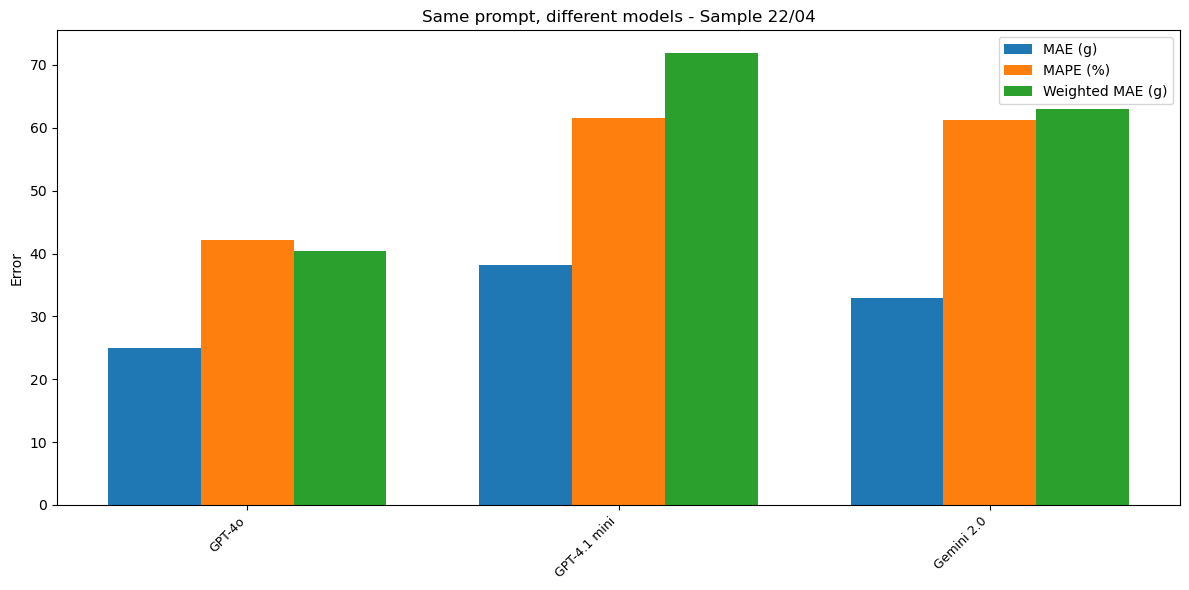

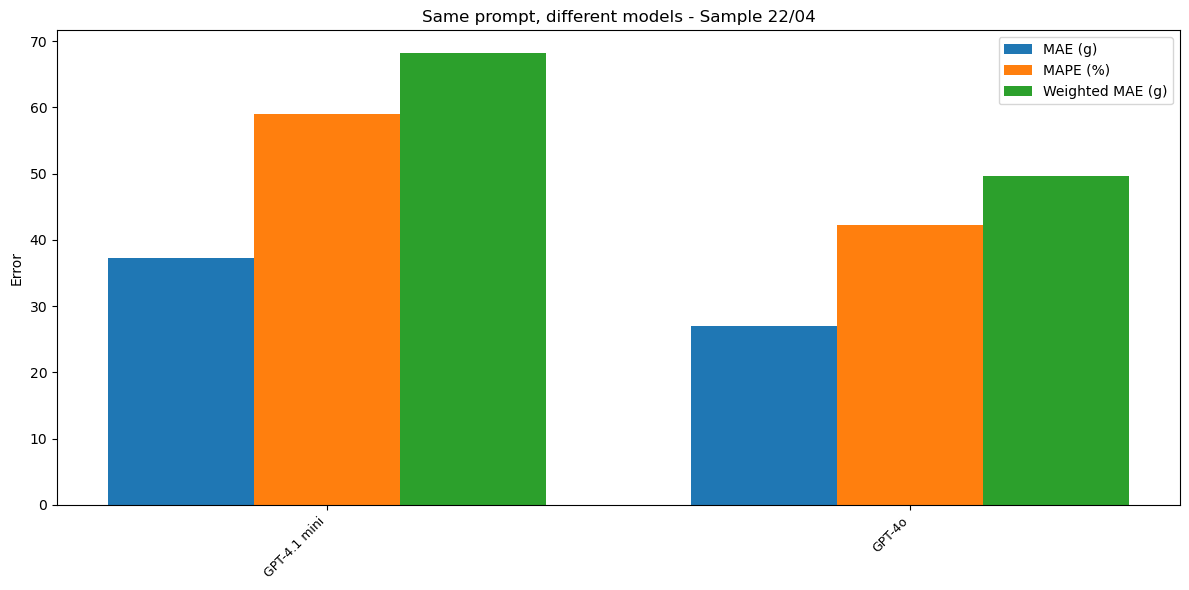

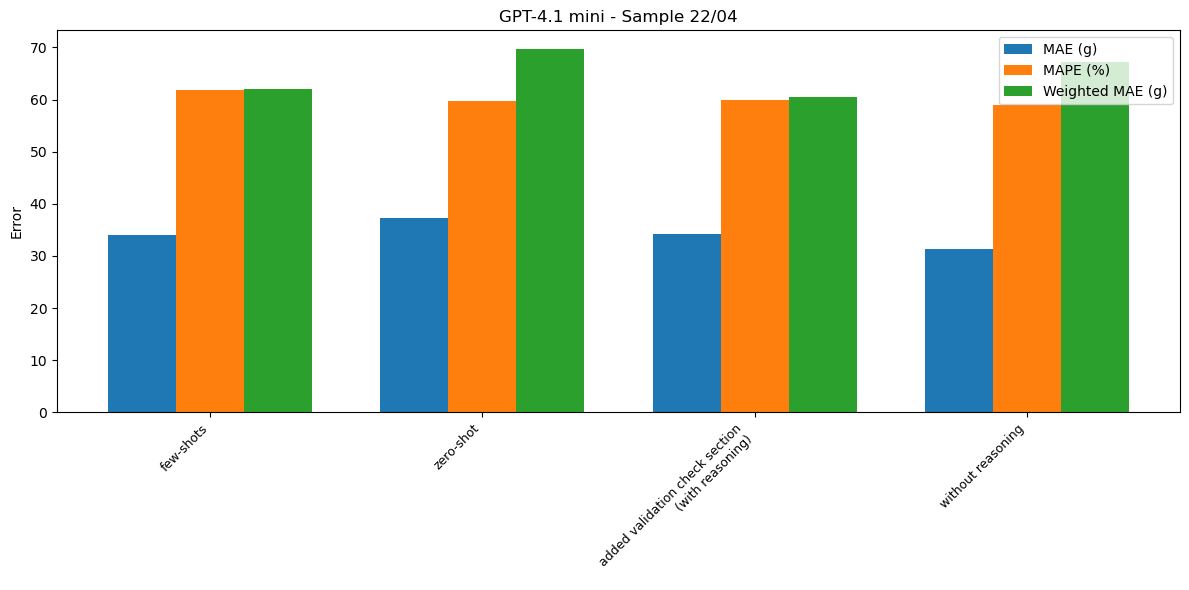

In [30]:
df4 = df.iloc[[49, 67, 70]].copy() 
plot_metrics(df4, "Same prompt, different models - Sample 22/04", label="model")

df5 = df.iloc[[68, 69]].copy() 
plot_metrics(df5, "Same prompt, different models - Sample 22/04", label="model")

df6 = df.iloc[[71, 72, 74, 75]].copy() 
plot_metrics(df6, "GPT-4.1 mini - Sample 22/04")